# Join Dataset

### GDrive setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [3]:
ls

anonymisedOUDataSet/  StudentAssessmentDaysDeadline.csv


## Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
assessments_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/assessments.csv')
courses_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/courses.csv')
student_assessments_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/studentAssessment.csv')
student_info_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/studentInfo.csv')
student_registration_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/studentRegistration.csv')
student_vle_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/studentVle.csv')
vle_df = pd.read_csv('../OULAD dataset/anonymisedOUDataSet/vle.csv')

sa_days_deadline_df = pd.read_csv('../OULAD dataset/StudentAssessmentDaysDeadline.csv')

sns.set(rc={'figure.figsize':(11.7,8.27)})

### Join assessment data with individual student assessments

In [6]:
# drop columns not required to join with student_assessments_df
assessments_df.drop(['code_presentation','assessment_type','date','weight'], axis = 1, inplace = True)
assessments_df.code_module.value_counts()

FFF    52
BBB    42
DDD    35
GGG    30
CCC    20
EEE    15
AAA    12
Name: code_module, dtype: int64

In [7]:
# merge each student assessments with assessment data
combined_assessment = pd.merge(student_assessments_df,assessments_df,on='id_assessment')
combined_assessment.drop(['is_banked','date_submitted'],axis = 1,inplace=True)
combined_assessment.head()

,id_assessment,id_student,score,code_module
0,1752,11391,78.0,AAA
1,1752,28400,70.0,AAA
2,1752,31604,72.0,AAA
3,1752,32885,69.0,AAA
4,1752,38053,79.0,AAA


In [8]:
# group assessments by student then course
grouped_student_assessments = combined_assessment.groupby(['id_student','code_module']).mean()
grouped_student_assessments.sort_values('id_student')

grouped_student_assessments.drop(['id_assessment'],axis=1,inplace = True)
grouped_student_assessments.head()

,,score
id_student,code_module,
6516,AAA,61.800000
8462,DDD,87.000000
11391,AAA,82.000000
23629,BBB,82.500000
23698,CCC,74.444444


#### Plot the number of modules each student takes

Text(0, 0.5, 'Number of students')

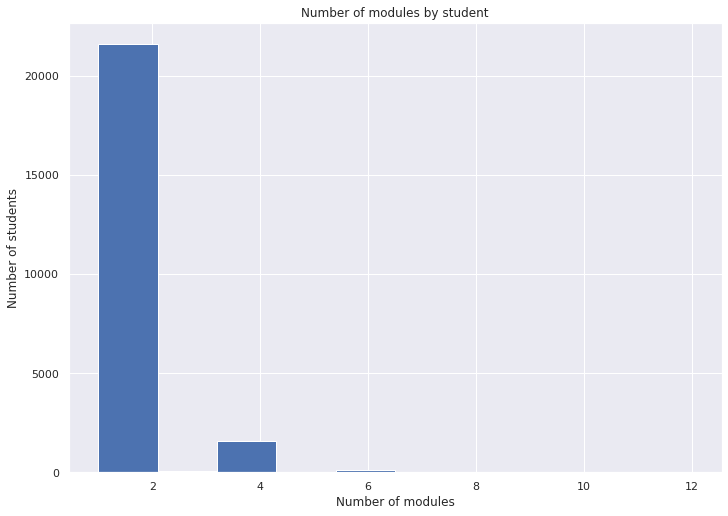

In [9]:
student_all_info = pd.merge(student_info_df,grouped_student_assessments,on='id_student')
fig1 = student_all_info.groupby(['id_student']).code_module.count().sort_values().hist()
fig1.set_title('Number of modules by student')
fig1.set_xlabel('Number of modules')
fig1.set_ylabel('Number of students')

#### Number of sum clicks per student

In [10]:
# number of clicks a student makes for a module a day
grouped_vle_sum_clicks = student_vle_df.groupby(['id_student','code_module']).sum()

# Remove uneeded columns
grouped_vle_sum_clicks.drop(['id_site','date'],axis=1,inplace=True)
grouped_vle_sum_clicks.head()

,,sum_click
id_student,code_module,
6516,AAA,2791
8462,DDD,656
11391,AAA,934
23629,BBB,161
23698,CCC,910


In [11]:
# merge grouped_vle_sum_clicks to student_all_info to a new dataframe called df
df = pd.merge(student_all_info,grouped_vle_sum_clicks,on = ['id_student','code_module'],how='left')

In [12]:
# remove rows with null
df.dropna(inplace=True)

In [13]:
# categorise df columns
df.code_module = pd.Categorical(df.code_module)
df.code_presentation = pd.Categorical(df.code_presentation)
df.gender = pd.Categorical(df.gender)
df.region = pd.Categorical(df.region)
df.highest_education = pd.Categorical(df.highest_education)
df.imd_band = pd.Categorical(df.imd_band)
df.age_band = pd.Categorical(df.age_band)
df.disability = pd.Categorical(df.disability)
df.final_result = pd.Categorical(df.final_result)

In [14]:
# replace final result string with numerical representation
df.final_result = df.final_result.replace({'Withdrawn':0,'Fail':1,'Pass':2,'Distinction':3})

### Module AAA - statistics

In [15]:
# select every 
module_AAA = df.loc[df['code_module'] == "AAA"]

#module_AAA = module_AAA.loc[module_AAA['sum_click'] > 50]

# 2 results - pass or fail
module_AAA['final_result'] = module_AAA['final_result'].replace({1:0, 2:1, 3:1})
module_AAA.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(690, 14)

In [16]:
module_AAA.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1,82.0,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1,66.4,1435.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1,76.0,2158.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1,54.4,1034.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1,68.0,2445.0


In [17]:
# students who completed the module >1 are included
module_AAA.groupby('id_student',as_index=False).size().sort_values(by='size')

,id_student,size
0,6516,1
424,958987,1
425,968578,1
426,969076,1
427,971027,1
...,...,...
600,2569324,2
603,2576122,2
363,470588,2
99,159954,2


In [18]:
# split students by pass or fail
module_AAA_fail = module_AAA.loc[module_AAA['final_result'] == 0]
module_AAA_pass = module_AAA.loc[module_AAA['final_result'] == 1]

#### Plot distribution of sum clicks by pass and fail

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of sum clicks by pass and fail')

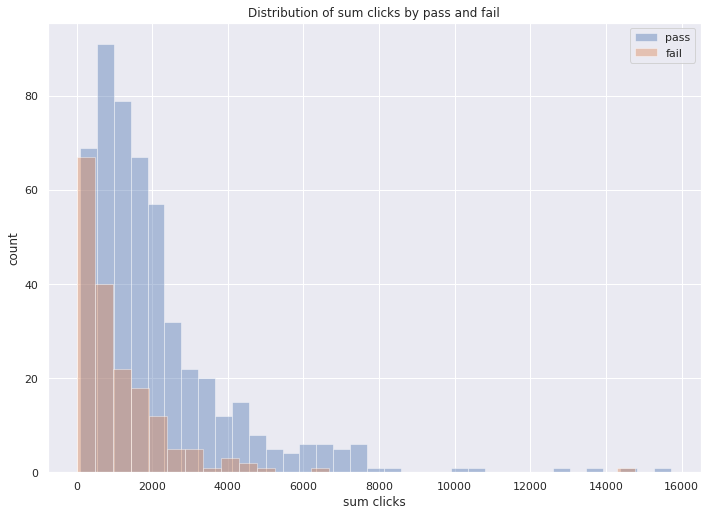

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(module_AAA_pass["sum_click"], kde=False)
sns.distplot(module_AAA_fail["sum_click"], kde=False)

plt.legend(labels=['pass',"fail"])

plt.xlabel("sum clicks")
plt.ylabel("count")

plt.title("Distribution of sum clicks by pass and fail")

#### Plot distribution of assessment scores by pass and fail

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of assessment scores by pass and fail')

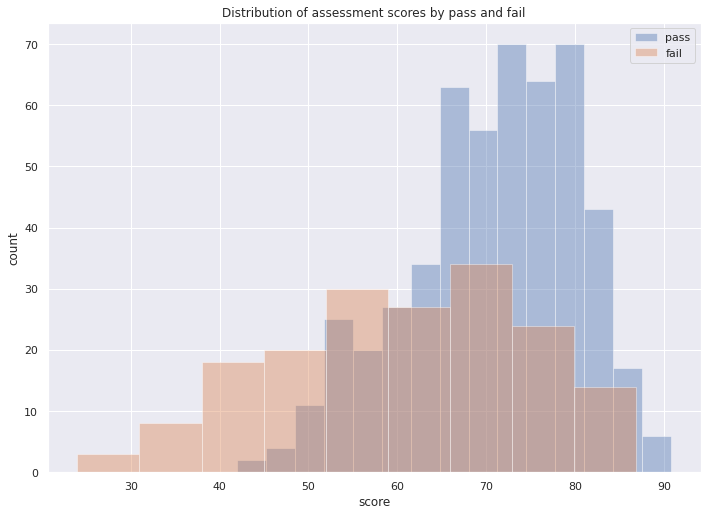

In [20]:
sns.distplot(module_AAA_pass["score"],kde=False)
sns.distplot(module_AAA_fail["score"],kde=False)

plt.legend(labels=['pass',"fail"])

plt.xlabel("score")
plt.ylabel("count")

plt.title("Distribution of assessment scores by pass and fail")

#### Plot final result by gender

Text(0, 0.5, 'Count')

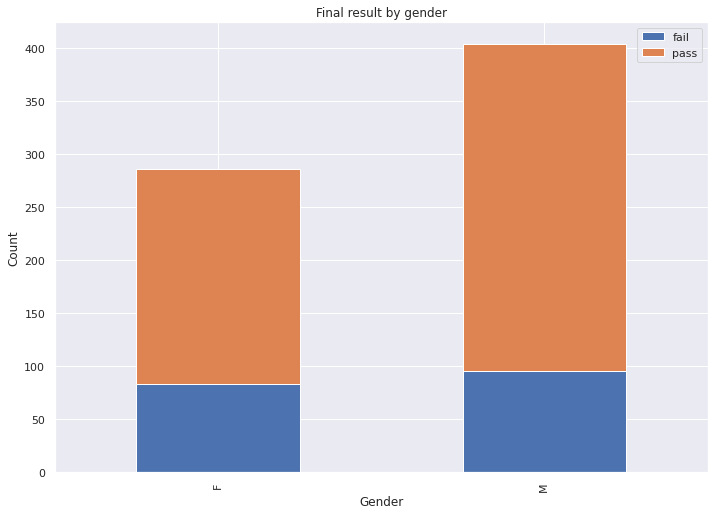

In [21]:
pd.crosstab(module_AAA['gender'],module_AAA['final_result']).plot.bar(stacked=True)
plt.title("Final result by gender")

plt.legend(labels=['fail','pass'])

plt.xlabel("Gender")
plt.ylabel("Count")

### Predictions

#### Evaluation

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score


def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision_macro = precision_score(true_labels, predictions, average='macro')
  precision_weighted = precision_score(true_labels, predictions, average='weighted')

  recall = recall_score(true_labels, predictions, average='macro')
  accuracy = accuracy_score(true_labels, predictions)
  f1 = fbeta_score(true_labels, predictions, beta=1, average='macro')#, labels=np.unique(predictions)) #1 means f_1 measure

  print("Classifier '%s' has Acc=%0.3f P_macro=%0.3f P_weighted=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision_macro,precision_weighted,recall,f1))
  # Specify three digits instead of the default two.
  print(classification_report(true_labels, predictions, digits=3))
  print('\nConfusion matrix:\n') # Note the order here is true, predicted, odd.
  cm = confusion_matrix(true_labels, predictions)
  labels = np.unique(true_labels)
  print(pd.DataFrame(cm, index=labels, columns=labels))

  plt.subplots(figsize=(8,7))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['fail', 'pass']); ax.yaxis.set_ticklabels(['fail', 'pass'])

#### Split dataset

In [23]:
from sklearn.model_selection import train_test_split

def split_dataset(X, Y):   
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
    return X_train, Y_train, X_test, Y_test


#### Prepare data

In [24]:
Y = df['final_result'].replace({1:0, 2:1, 3:1}) # Fail, Withdraw, Pass, Distinction -> Incomplete, Complete
X = df.drop('final_result', axis=1)

# Convert categorical variable into indicator variables. One-hot encoding
X = pd.get_dummies(X)

In [25]:
X_train, Y_train, X_test, Y_test = split_dataset(X,Y)

#### Decision Tree Classifier

Evaluation for: Decision Tree Classifier test dataset
Classifier 'Decision Tree Classifier test dataset' has Acc=0.755 P_macro=0.749 P_weighted=0.754 R=0.748 F1=0.749
              precision    recall  f1-score   support

           0      0.716     0.702     0.709      3080
           1      0.782     0.794     0.788      4155

    accuracy                          0.755      7235
   macro avg      0.749     0.748     0.749      7235
weighted avg      0.754     0.755     0.754      7235


Confusion matrix:

      0     1
0  2162   918
1   856  3299


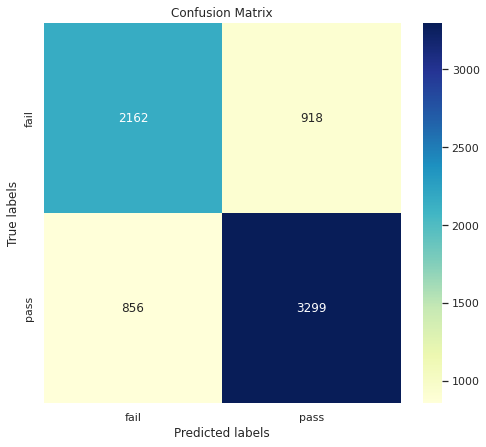

In [30]:
from sklearn.tree import DecisionTreeClassifier 

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, Y_train)

test_dt_predictions = dt_classifier.predict( X_test)

evaluation_summary("Decision Tree Classifier test dataset",  test_dt_predictions, Y_test)